## 0. Load datasets

In [86]:
%load_ext autoreload
%autoreload 1

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path
import ipyvolume as ipv

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection
from sklearn import ensemble, metrics, inspection

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    forests = []
    for i in tqdm(range(Niter)):
        
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs('Measurement',level=1,axis=1).astype(float)
        X = preprocessing.scale(X)
        
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = classifier.fit(X_train,y_train)
        forests.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),forests]
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    _df['Region'] = name
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [88]:
len(all_df)

15087

In [89]:
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]
basals = basals[basals['Frac of neighbors are border','Meta'] < .2]
len(basals)


3820

### Isolate specific time points

In [4]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']

births = df[df['Birth frame','Meta']]
births_raw = births.copy()
print(f'Number of births: {len(births)}')

df = all_df[~np.isnan(all_df['Both daughters differentiated','Meta'].astype(float))]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]].copy()
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index()
print(f'Number of mother divisions: {len(divisions)}')

prev_div_frame = [get_prev_or_next_frame(df,f,direction='prev') for _,f in divisions.iterrows()]
prev_div_frame = pd.concat(prev_div_frame,axis=1,ignore_index=False).T
#@todo: investigate efficiency of force-casting at different points
for col in df.columns:
    prev_div_frame[col] = prev_div_frame[col].astype(df[col].dtype)
prev_div_frame = prev_div_frame[~prev_div_frame['Border','Meta'].astype(bool)]
prev_div_frame = prev_div_frame.reset_index().rename(columns={'level_0':'Frame','level_1':'TrackID'}).set_index('TrackID')
print(f'Number of 12h prior to divisions: {len(prev_div_frame)}')

prev2_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=2) for _,f in divisions.iterrows()]
prev2_div_frame = pd.concat(prev2_div_frame,axis=1).T
prev2_div_frame = prev2_div_frame[~prev2_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev2_div_frame[col] = prev2_div_frame[col].astype(df[col].dtype)
print(f'Number of 24h prior to divisions: {len(prev2_div_frame)}')

prev3_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=3) for _,f in divisions.iterrows()]
prev3_div_frame = pd.concat(prev3_div_frame,axis=1).T
prev3_div_frame = prev3_div_frame[~prev3_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev3_div_frame[col] = prev3_div_frame[col].astype(df[col].dtype)
print(f'Number of 36h prior to divisions: {len(prev3_div_frame)}')

prev4_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=4) for _,f in divisions.iterrows()]
prev4_div_frame = pd.concat(prev4_div_frame,axis=1).T
prev4_div_frame = prev4_div_frame[~prev4_div_frame['Border','Meta'].astype(bool)]
for col in df.columns:
    prev4_div_frame[col] = prev4_div_frame[col].astype(df[col].dtype)
print(f'Number of 48h prior to divisions: {len(prev4_div_frame)}')


Number of births: 764
Number of mother divisions: 307
Number of 12h prior to divisions: 243
Number of 24h prior to divisions: 206
Number of 36h prior to divisions: 157
Number of 48h prior to divisions: 115


#### Filter out features

Manually censor some features

In [5]:
# Censor age / time til diff
features2drop = [f for f in births.columns.get_level_values(0) if 'Time to differentiation' in f]
features2drop += [f for f in births.columns.get_level_values(0) if 'Age' in f]
# Censor height information
features2drop = features2drop + ['Z','Mean curvature - cell coords','Z-cyto','Height to BM',
                                 'Basal area','Apical area','Relative Height to BM','Relative Height to BM at 1 frame prior']
# Censor all exponential rates (but not mother's)
features2drop = features2drop + [f for f in births.columns.get_level_values(0)
                                 if ('exponential' in f and 'frame prior' not in f \
                                         and 'G1' not in f)]

np.isnan(births['Cell volume G1 only exponential growth rate']).sum()

Metadata
Measurement    348
dtype: int64

Manage the feature names

In [280]:
metas = pd.DataFrame()
metas['name'] = births.xs('Meta',level=1,axis=1).columns
features = pd.DataFrame()

meas = births.xs('Measurement',level=1,axis=1)
features['name'] = meas.columns
features =features.set_index('name')
features['Num NA'] = meas.isna().sum(axis=0)
feature_names = features.index
num_nas = (features['Num NA'] > 0).sum()

# print(f'Number of features with NAs: {num_nas}')
# print(features.sort_values('Num NA').tail(50))

# Set the acceptable number of NAs (will be dropped)
na_thresh = 350
features2drop += features[features['Num NA'] > na_thresh].index.values.tolist()

births = births.drop(columns=features2drop)
divisions = divisions.drop(columns=features2drop)
prev_div_frame = prev_div_frame.drop(columns=features2drop)
prev2_div_frame = prev2_div_frame.drop(columns=features2drop)

NameError: name 'births' is not defined

In [7]:
# Drop the NA samples and update the leftover features list

births = births.dropna(axis=0,subset=[(a,b) for (a,b) in births.columns if b == 'Measurement'], how='any')
divisions = divisions.dropna(axis=1)
prev_div_frame = prev_div_frame.dropna(axis=1)
prev2_div_frame = prev2_div_frame.dropna(axis=1)

print('---')
print(f'Number of births: {len(births)}')
print(f'Number of mother divisions: {len(divisions)}')
print(f'Number of 12h prior to divisions: {len(prev_div_frame)}')
print(f'Number of 24h prior to divisions: {len(prev2_div_frame)}')

print('---')
print(f'Births: {len(births.columns)} features')
print(f'Mother divisions: {len(divisions.columns)} features')
print(f'12h prior to divisions: {len(prev_div_frame.columns)} features')
print(f'24h prior to divisions: {len(prev2_div_frame.columns)} features')

birth_feature_set = births.xs('Measurement',level=1,axis=1).columns
conservative_feature_set = prev2_div_frame.xs('Measurement',level=1,axis=1).columns
assert(np.isnan(births[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(divisions[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(prev_div_frame[conservative_feature_set]).values.sum() == 0)
assert(np.isnan(prev2_div_frame[conservative_feature_set]).values.sum() == 0)

---
Number of births: 377
Number of mother divisions: 307
Number of 12h prior to divisions: 243
Number of 24h prior to divisions: 206
---
Births: 1366 features
Mother divisions: 781 features
12h prior to divisions: 779 features
24h prior to divisions: 778 features


## Probabilistic PCA to avoid imputation / censoring

In [90]:
from ppca import PPCA
from sklearn import preprocessing
ppca = PPCA()

model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Probabilistic PCA'
features2drop = ['X','Y','Z','X-pixels','Y-pixels','X-cyto','Y-cyto','Z-cyto']

X_ = basals.xs('Measurement',axis=1,level=1).drop(columns=features2drop)
feature_names = X_.columns
X = X_.values
X[np.isinf(X)] = np.nan
X = preprocessing.scale(X)
ppca.fit(data=X, d=100, verbose=False)
ppca.save(path.join(model_dir,'ppca.model'))
X_transformed = ppca.transform(X)

Text(0, 0.5, '% variance explained')

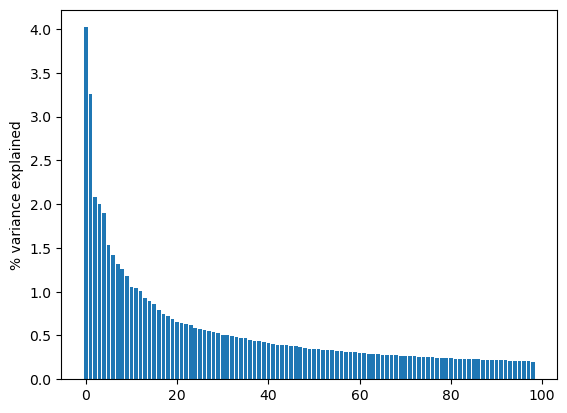

In [94]:
variance_explained = ppca.var_exp
loadings = ppca.C
X_transformed = ppca.transform()

plt.bar(range(99),np.diff(variance_explained)*100);plt.ylabel('% variance explained')

In [92]:
loadings.shape
components = pd.DataFrame(loadings,index=feature_names)
X_transformed.shape

(3820, 100)

In [93]:
ppca.var_exp[4]*100

15.872556246043375

### PC0

<Axes: xlabel='Name'>

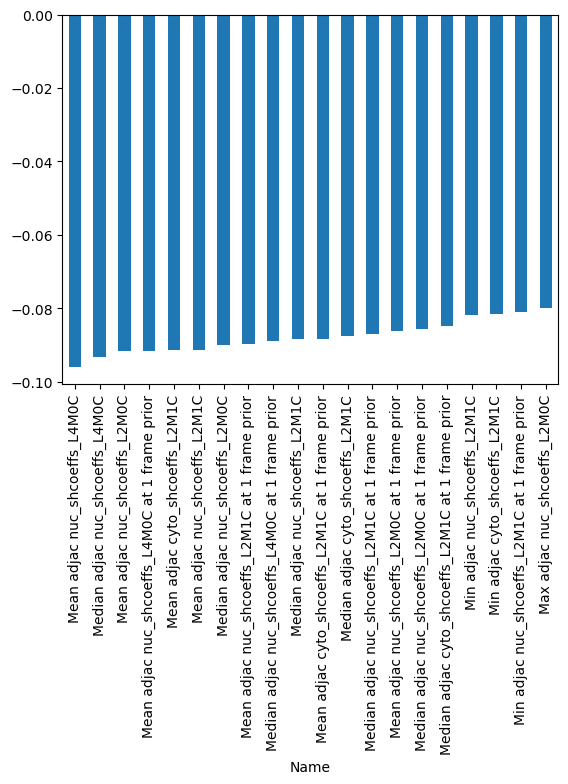

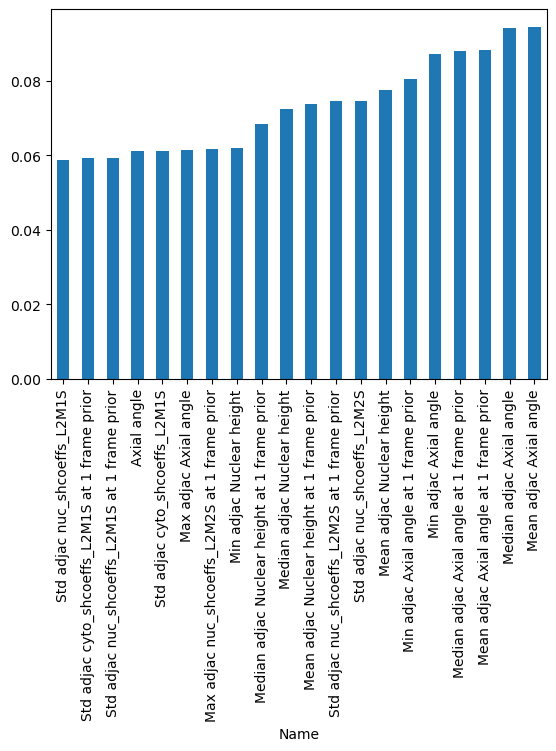

In [95]:
components[0].sort_values().head(20).plot.bar()
plt.figure()
components[0].sort_values().tail(20).plot.bar()

### PC1

<Axes: xlabel='Name'>

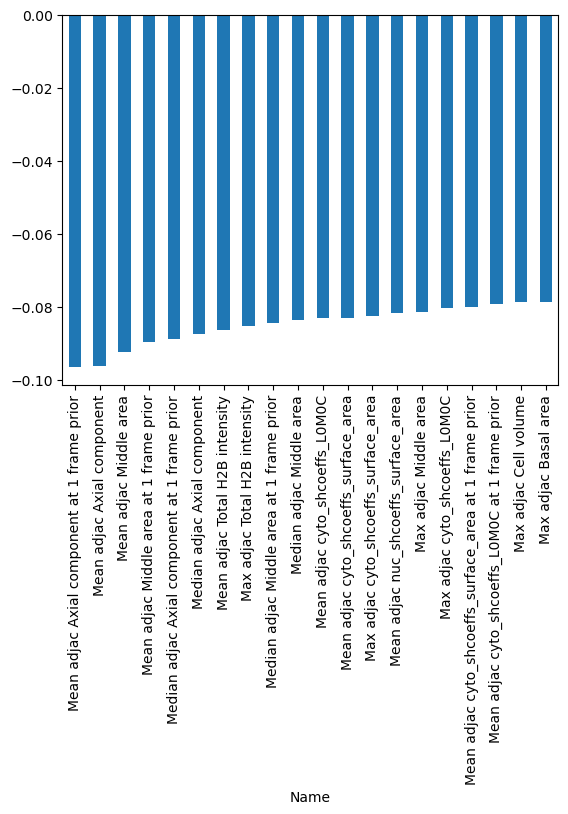

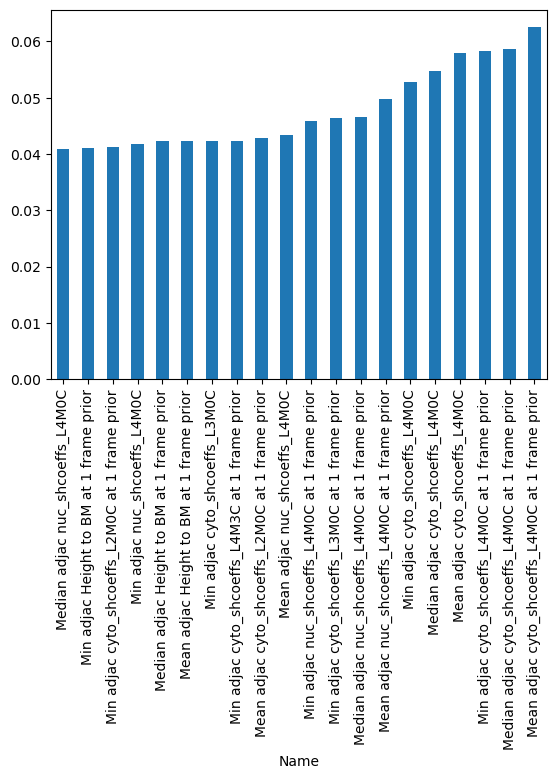

In [66]:
components[1].sort_values().head(20).plot.bar()
plt.figure()
components[1].sort_values().tail(20).plot.bar()

### PC2

<Axes: xlabel='Name'>

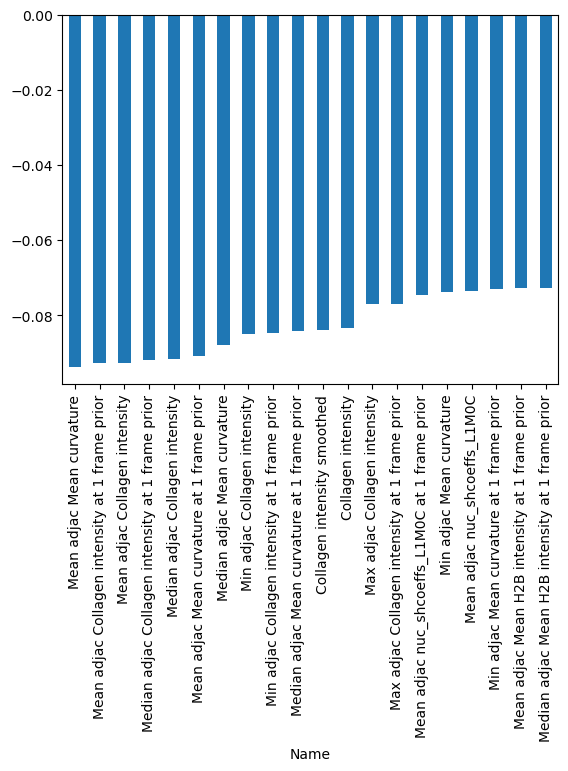

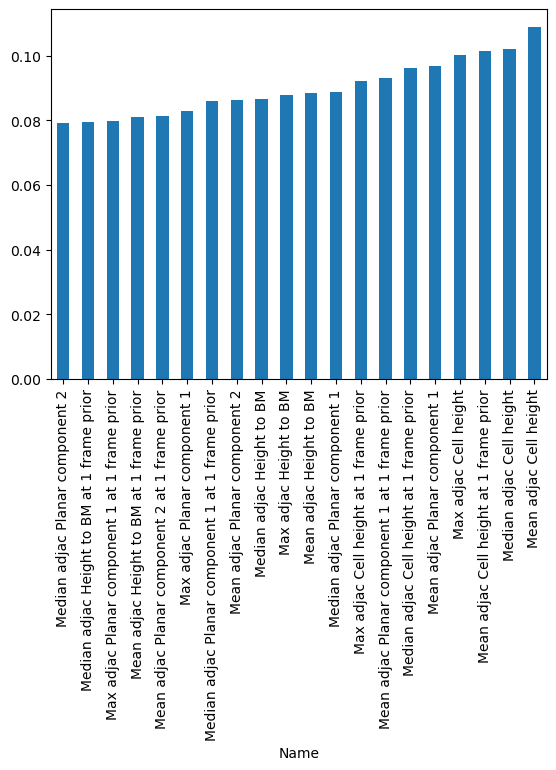

In [67]:
components[2].sort_values().head(20).plot.bar()
plt.figure()
components[2].sort_values().tail(20).plot.bar()

### PC3

<Axes: xlabel='Name'>

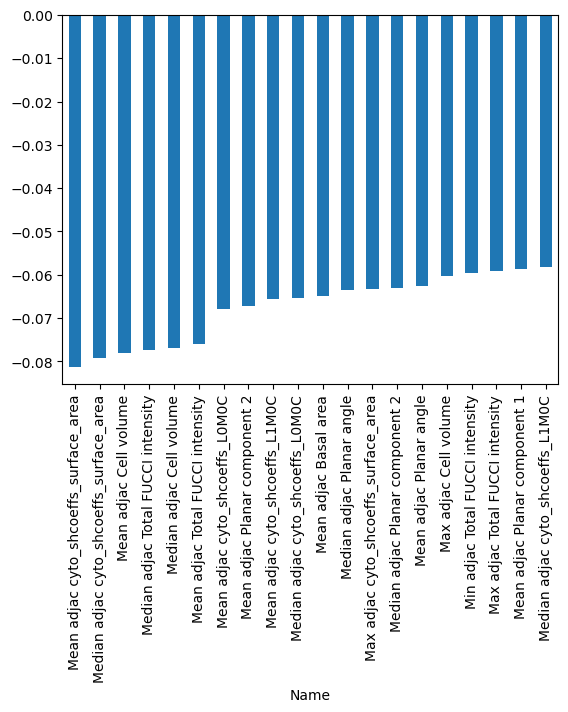

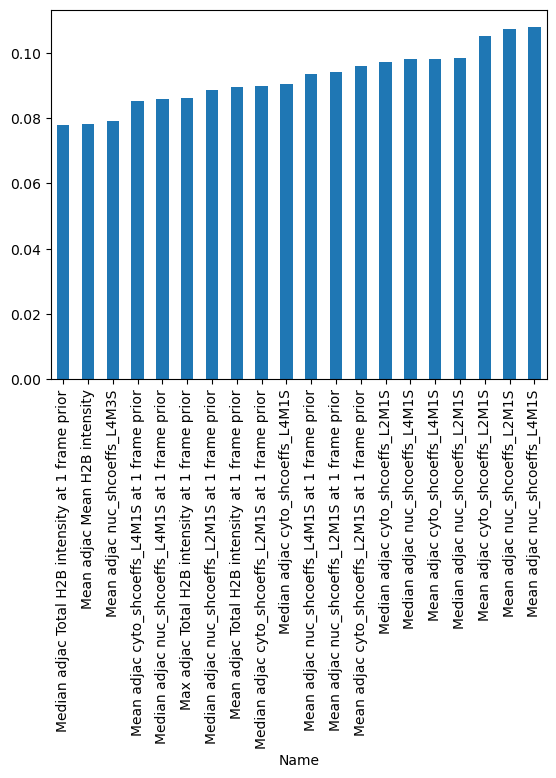

In [68]:
components[3].sort_values().head(20).plot.bar()
plt.figure()
components[3].sort_values().tail(20).plot.bar()

### PC4

<Axes: xlabel='Name'>

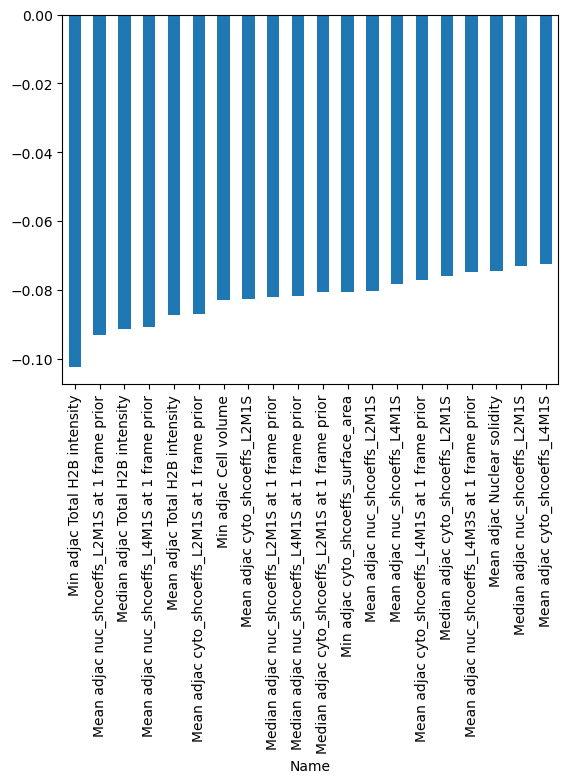

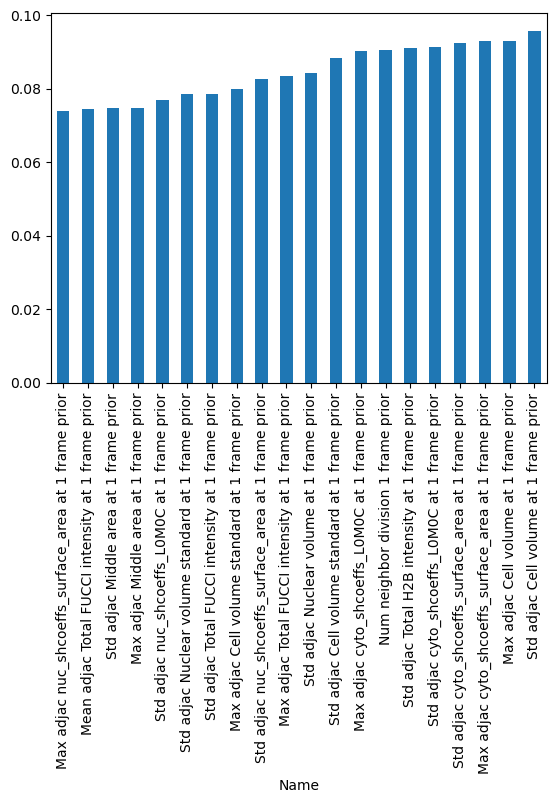

In [73]:
components[4].sort_values().head(20).plot.bar()
plt.figure()
components[4].sort_values().tail(20).plot.bar()


### PC5

<Axes: xlabel='Name'>

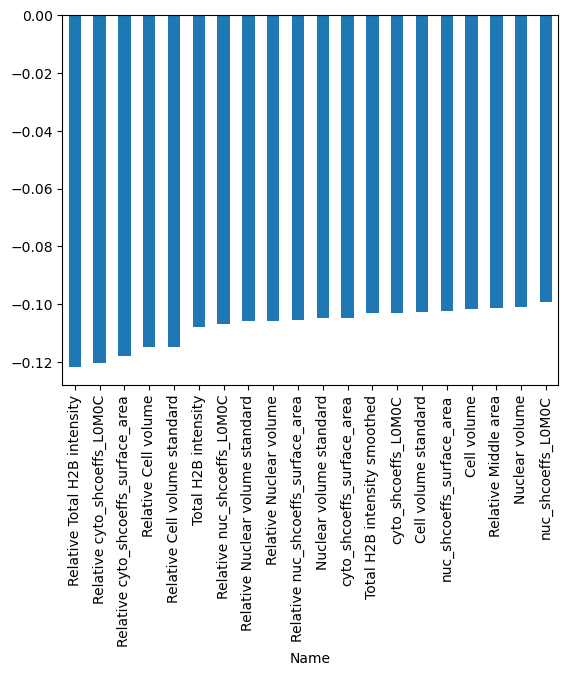

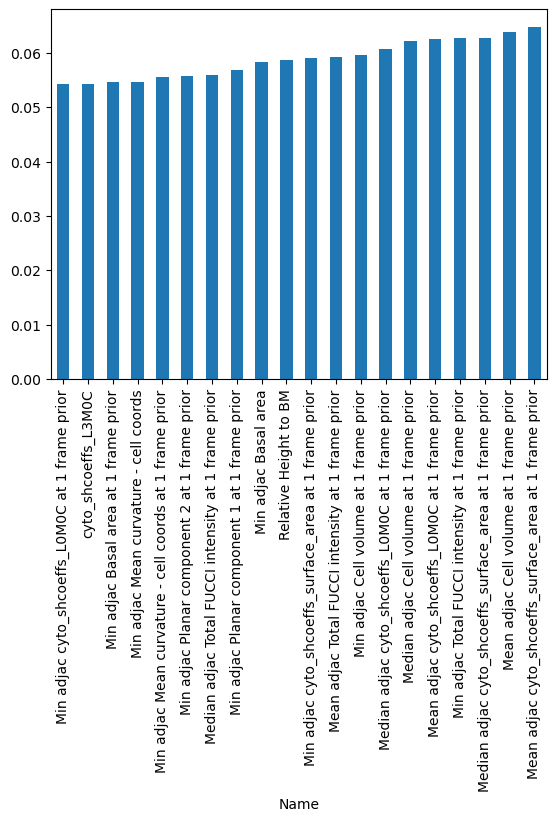

In [74]:
components[5].sort_values().head(20).plot.bar()
plt.figure()
components[5].sort_values().tail(20).plot.bar()


<Axes: >

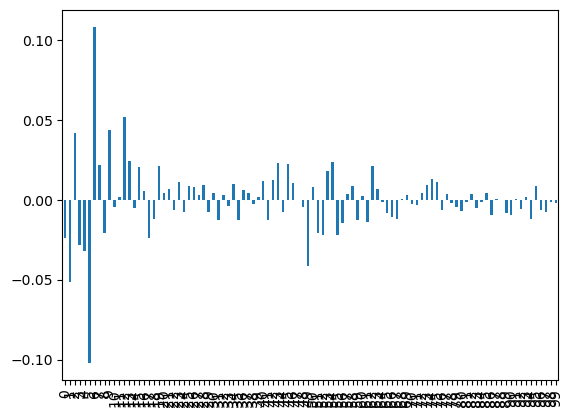

In [75]:
components.loc['Cell volume'].plot.bar()

### Visualize exemplars

In [96]:
# Load images
from skimage import io

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}

%autoreload 2


#### PC0 examples

In [97]:
from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx

# Pull out 3 examplar 'PC0' cells
pc0_exemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,0])[-100:]]
pc0_masks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc0_exemplars]

pc0_cells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc0_masks]

# Pull out 3 anti-examplar 'PC0' cells
pc0_antiexemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,0])[:100]]
pc0_antimasks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc0_antiexemplars]
pc0_anticells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc0_antimasks]

print(pc0_exemplars)
print(pc0_antiexemplars)

MultiIndex([(14,  'R1_826'),
            (13, 'R2_1058'),
            (12, 'R2_1087'),
            (14, 'R2_1099'),
            (13,  'R2_119'),
            ( 3,   'R2_31'),
            ( 2,  'R2_352'),
            ( 5,  'R2_176'),
            ( 4, 'R2_1078'),
            ( 1,  'R2_906'),
            ( 0, 'R2_1100'),
            ( 5,  'R2_726'),
            ( 3,  'R2_418'),
            (14,  'R2_509'),
            (13,  'R2_512'),
            ( 4,   'R2_31'),
            ( 1, 'R2_1100'),
            ( 4,  'R2_151'),
            ( 5,  'R2_615'),
            ( 2,  'R2_282'),
            ( 1,  'R2_329'),
            ( 3,  'R2_473'),
            (14,  'R2_333'),
            ( 2,   'R2_11'),
            ( 1, 'R2_1051'),
            ( 0, 'R2_1051'),
            ( 5, 'R2_1050'),
            ( 6,  'R2_173'),
            ( 4,  'R2_615'),
            (13,  'R2_332'),
            ( 2, 'R2_1080'),
            (13,  'R1_982'),
            ( 1,  'R2_825'),
            ( 4,  'R2_352'),
            ( 

##### Exemplar PC0 cell

In [87]:
ipv.quickvolshow(pc0_cells[3], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

##### Anti-exemplar PC0 cell

In [91]:
ipv.quickvolshow(pc0_anticells[5], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

#### PC1 examples

In [99]:
# Pull out 3 examplar 'PC1' cells
pc1_exemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,1])[-100:]]
pc1_masks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc1_exemplars]
pc1_cells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc1_masks]

# Pull out 3 anti-examplar 'PC1' cells
pc1_antiexemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,1])[:100]]
pc1_antimasks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc1_antiexemplars]
pc1_anticells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc1_antimasks]

print(pc1_exemplars)
print(pc1_antiexemplars)

MultiIndex([(10,  'R2_578'),
            (11,  'R2_756'),
            (10,  'R1_390'),
            ( 9,  'R2_593'),
            ( 6,  'R2_470'),
            ( 7,  'R2_643'),
            ( 6,  'R2_825'),
            ( 6,  'R2_168'),
            ( 9,  'R2_292'),
            ( 9,  'R1_135'),
            ( 7,  'R1_928'),
            ( 7,  'R2_795'),
            ( 9,  'R2_487'),
            ( 9,  'R1_836'),
            ( 7,   'R2_58'),
            ( 7,  'R2_349'),
            ( 7,  'R1_533'),
            ( 9, 'R2_1092'),
            (10,  'R1_122'),
            (10,  'R2_415'),
            ( 7,  'R2_835'),
            (10,  'R2_308'),
            (11,   'R2_27'),
            (11,  'R1_110'),
            ( 7,  'R2_292'),
            ( 9,  'R2_388'),
            ( 9,   'R2_59'),
            ( 8,  'R2_470'),
            (10,  'R2_759'),
            (11,  'R1_398'),
            (12,  'R1_579'),
            ( 7,  'R2_561'),
            ( 7,  'R2_430'),
            (10,  'R1_259'),
            ( 

##### Exemplar PC1 cell

In [100]:
ipv.quickvolshow(pc1_cells[3], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [105]:
ipv.quickvolshow(pc1_anticells[6], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

#### PC2 examples

In [100]:
# Pull out 3 examplar 'PC2' cells
pc2_exemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,2])[-100:]]
pc2_masks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc2_exemplars]
pc2_cells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc2_masks]

# Pull out 3 anti-examplar 'PC2' cells
pc2_antiexemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,2])[:100]]
pc2_antimasks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc2_antiexemplars]
pc2_anticells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc2_antimasks]

# print(pc2_exemplars)
# print(pc2_antiexemplars)

In [120]:
ipv.quickvolshow(pc2_cells[14], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [121]:
ipv.quickvolshow(pc2_anticells[24], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

#### PC3 examples

In [98]:
# Pull out 3 examplar 'PC3' cells
pc3_exemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,3])[-50:]]
pc3_masks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc3_exemplars]
pc3_cells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc3_masks]

# Pull out 3 anti-examplar 'PC3' cells
pc3_antiexemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,3])[:50]]
pc3_antimasks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc3_antiexemplars]
pc3_anticells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc3_antimasks]

# print(pc3_exemplars)
# print(pc3_antiexemplars)

In [131]:
ipv.quickvolshow(pc3_cells[4], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [130]:
ipv.quickvolshow(pc3_anticells[3], level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [78]:
# Pull out 3 examplar 'PC3' cells
pc5_exemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,5])[-50:]]
pc5_masks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc5_exemplars]
pc5_cells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc5_masks]

# Pull out 3 anti-examplar 'PC5' cells
pc5_antiexemplars = basals.xs('Measurement',level=1,axis=1).index[np.argsort(X_transformed[:,5])[:50]]
pc5_antimasks = [extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region) for idx in pc5_antiexemplars]
pc5_anticells = [1*n.astype(float) + 2*c.astype(float) + 1*m.astype(float) for n,c,m in pc5_antimasks]

# print(pc5_exemplars)
# print(pc5_antiexemplars)

## Average PC cells

In [101]:
from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx
from imageUtils import trim_multimasks_to_shared_bounding_box, pad_image_to_size_centered, create_average_object_from_multiple_masks

standard_size = (30,150,150)

def get_display_of_average_nuc_cyto_micro(ncm_list,largest_size=None):
    nuc = [m[0] for m in ncm_list]
    cyto = [m[1] for m in ncm_list]
    micro = [m[2] for m in ncm_list]
    nuc = create_average_object_from_multiple_masks(nuc,prealign=False)
    cyto = create_average_object_from_multiple_masks(cyto,prealign=False)
    micro = create_average_object_from_multiple_masks(micro,prealign=False)

    if largest_size is None:
        largest_size = np.array((nuc.shape,cyto.shape,micro.shape)).max(axis=0)
    nuc = pad_image_to_size_centered(nuc,largest_size)
    cyto = pad_image_to_size_centered(cyto,largest_size)
    micro = pad_image_to_size_centered(micro,largest_size)
    return nuc,cyto,micro

pc0_nuc,pc0_cyto,pc0_micro = get_display_of_average_nuc_cyto_micro(pc0_masks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_example.tif'),mean_pc0)
antipc0_nuc,antipc0_cyto,antipc0_micro = get_display_of_average_nuc_cyto_micro(pc0_antimasks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_antiexample.tif'),mean_pc0)


In [102]:
ipv.quickvolshow(pc0_cyto, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

/opt/miniconda3/envs/python39/lib/python3.9/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [103]:
ipv.quickvolshow(antipc0_cyto, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [104]:

pc1_nuc,pc1_cyto,pc1_micro = get_display_of_average_nuc_cyto_micro(pc1_masks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_example.tif'),mean_pc0)
antipc1_nuc,antipc1_cyto,antipc1_micro = get_display_of_average_nuc_cyto_micro(pc1_antimasks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_antiexample.tif'),mean_pc0)


In [105]:
ipv.quickvolshow(pc1_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [106]:
ipv.quickvolshow(antipc1_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [48]:
pc2_nuc,pc2_cyto,pc2_micro = get_display_of_average_nuc_cyto_micro(pc2_masks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_example.tif'),mean_pc0)
antipc2_nuc,antipc2_cyto,antipc2_micro = get_display_of_average_nuc_cyto_micro(pc2_antimasks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_antiexample.tif'),mean_pc0)


In [51]:
ipv.quickvolshow(pc2_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [52]:
ipv.quickvolshow(antipc2_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [53]:
pc3_nuc,pc3_cyto,pc3_micro = get_display_of_average_nuc_cyto_micro(pc3_masks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_example.tif'),mean_pc0)
antipc3_nuc,antipc3_cyto,antipc3_micro = get_display_of_average_nuc_cyto_micro(pc3_antimasks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_antiexample.tif'),mean_pc0)


In [57]:
ipv.quickvolshow(pc3_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [56]:
ipv.quickvolshow(antipc3_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [79]:
pc5_nuc,pc5_cyto,pc5_micro = get_display_of_average_nuc_cyto_micro(pc5_masks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_example.tif'),mean_pc0)
antipc5_nuc,antipc5_cyto,antipc5_micro = get_display_of_average_nuc_cyto_micro(pc5_antimasks,standard_size)
# io.imsave(path.join(model_dir,'mean_cell/pc0_antiexample.tif'),mean_pc0)


In [80]:
ipv.quickvolshow(pc5_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

/opt/miniconda3/envs/python39/lib/python3.9/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [81]:
ipv.quickvolshow(antipc5_cyto, level=[.2,.7, 1], opacity=0.05, level_width=0.05, data_min=0, data_max=3)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [44]:
things2plot = ['Cell volume','Nuclear volume','NC ratio']
print('--PC0--')
print( basals.loc[pc0_exemplars][things2plot].mean() )
print( basals.loc[pc0_antiexemplars][things2plot].mean() )
print('--PC1--')
print( basals.loc[pc1_exemplars][things2plot].mean() )
print( basals.loc[pc1_antiexemplars][things2plot].mean() )
print('--PC2--')
print( basals.loc[pc2_exemplars][things2plot].mean() )
print( basals.loc[pc2_antiexemplars][things2plot].mean() )
print('--PC3--')
print( basals.loc[pc3_exemplars][things2plot].mean() )
print( basals.loc[pc3_antiexemplars][things2plot].mean() )

--PC0--
Name            Metadata   
Cell volume     Measurement    422.162500
Nuclear volume  Measurement    138.360625
NC ratio        Measurement      0.334808
dtype: float64
Name            Metadata   
Cell volume     Measurement    543.962500
Nuclear volume  Measurement    201.405000
NC ratio        Measurement      0.372769
dtype: float64
--PC1--
Name            Metadata   
Cell volume     Measurement    394.341875
Nuclear volume  Measurement    131.793125
NC ratio        Measurement      0.337323
dtype: float64
Name            Metadata   
Cell volume     Measurement    580.870625
Nuclear volume  Measurement    203.662500
NC ratio        Measurement      0.354435
dtype: float64
--PC2--
Name            Metadata   
Cell volume     Measurement    522.453125
Nuclear volume  Measurement    172.024375
NC ratio        Measurement      0.332820
dtype: float64
Name            Metadata   
Cell volume     Measurement    387.328750
Nuclear volume  Measurement    150.286250
NC ratio        Mea

In [45]:
things2plot = ['Basal orientation','Axial angle','Mean curvature']
print('--PC0--')
print( basals.loc[pc0_exemplars][things2plot].mean() )
print( basals.loc[pc0_antiexemplars][things2plot].mean() )
print('--PC1--')
print( basals.loc[pc1_exemplars][things2plot].mean() )
print( basals.loc[pc1_antiexemplars][things2plot].mean() )
print('--PC2--')
print( basals.loc[pc2_exemplars][things2plot].mean() )
print( basals.loc[pc2_antiexemplars][things2plot].mean() )
print('--PC3--')
print( basals.loc[pc3_exemplars][things2plot].mean() )
print( basals.loc[pc3_antiexemplars][things2plot].mean() )

--PC0--
Name               Metadata   
Basal orientation  Measurement     8.136182
Axial angle        Measurement    30.894195
Mean curvature     Measurement    -0.090514
dtype: float64
Name               Metadata   
Basal orientation  Measurement   -15.210537
Axial angle        Measurement    10.163491
Mean curvature     Measurement    -0.180925
dtype: float64
--PC1--
Name               Metadata   
Basal orientation  Measurement   -4.673113
Axial angle        Measurement    9.786560
Mean curvature     Measurement   -0.123464
dtype: float64
Name               Metadata   
Basal orientation  Measurement    -1.071697
Axial angle        Measurement    19.661408
Mean curvature     Measurement    -0.094551
dtype: float64
--PC2--
Name               Metadata   
Basal orientation  Measurement     9.958904
Axial angle        Measurement    18.158746
Mean curvature     Measurement    -0.429059
dtype: float64
Name               Metadata   
Basal orientation  Measurement    -5.930650
Axial angle   

In [46]:
things2plot = ['Basal area','Middle area','Apical area']
print('--PC0--')
print( basals.loc[pc0_exemplars][things2plot].mean() )
print( basals.loc[pc0_antiexemplars][things2plot].mean() )
print('--PC1--')
print( basals.loc[pc1_exemplars][things2plot].mean() )
print( basals.loc[pc1_antiexemplars][things2plot].mean() )
print('--PC2--')
print( basals.loc[pc2_exemplars][things2plot].mean() )
print( basals.loc[pc2_antiexemplars][things2plot].mean() )
print('--PC3--')
print( basals.loc[pc3_exemplars][things2plot].mean() )
print( basals.loc[pc3_antiexemplars][things2plot].mean() )

--PC0--
Name         Metadata   
Basal area   Measurement    35.700625
Middle area  Measurement    36.710625
Apical area  Measurement    19.028750
dtype: float64
Name         Metadata   
Basal area   Measurement    40.478125
Middle area  Measurement    42.100625
Apical area  Measurement    14.987500
dtype: float64
--PC1--
Name         Metadata   
Basal area   Measurement    32.920625
Middle area  Measurement    31.512500
Apical area  Measurement    13.825625
dtype: float64
Name         Metadata   
Basal area   Measurement    50.729375
Middle area  Measurement    48.182500
Apical area  Measurement    17.685000
dtype: float64
--PC2--
Name         Metadata   
Basal area   Measurement    27.698750
Middle area  Measurement    37.146875
Apical area  Measurement    13.823750
dtype: float64
Name         Metadata   
Basal area   Measurement    40.931250
Middle area  Measurement    37.326250
Apical area  Measurement    18.584375
dtype: float64
--PC3--
Name         Metadata   
Basal area   Measur

In [85]:
things2plot = ['Collagen intensity','Basal alignment','Planar angle']
print('--PC0--')
print( basals.loc[pc0_exemplars][things2plot].mean() )
print( basals.loc[pc0_antiexemplars][things2plot].mean() )
print('--PC1--')
print( basals.loc[pc1_exemplars][things2plot].mean() )
print( basals.loc[pc1_antiexemplars][things2plot].mean() )
print('--PC2--')
print( basals.loc[pc2_exemplars][things2plot].mean() )
print( basals.loc[pc2_antiexemplars][things2plot].mean() )
print('--PC3--')
print( basals.loc[pc3_exemplars][things2plot].mean() )
print( basals.loc[pc3_antiexemplars][things2plot].mean() )


--PC0--
Name                Metadata   
Collagen intensity  Measurement     0.292775
Basal alignment     Measurement     0.623378
Planar angle        Measurement    90.849947
dtype: float64
Name                Metadata   
Collagen intensity  Measurement     0.475442
Basal alignment     Measurement     0.691363
Planar angle        Measurement    88.508569
dtype: float64
--PC1--
Name                Metadata   
Collagen intensity  Measurement     0.322917
Basal alignment     Measurement     0.591516
Planar angle        Measurement    92.654893
dtype: float64
Name                Metadata   
Collagen intensity  Measurement     0.582287
Basal alignment     Measurement     0.690188
Planar angle        Measurement    85.639889
dtype: float64
--PC2--
Name                Metadata   
Collagen intensity  Measurement     0.180978
Basal alignment     Measurement     0.606231
Planar angle        Measurement    88.671336
dtype: float64
Name                Metadata   
Collagen intensity  Measurement   